# SIIM-FISABIO_RSNA COVID-19 Detection

COVID-19 는 폐에 염증과 체액을 초래한다.
흉부 방사선 사진에서 다른 바이러스 및 세균성 페렴과 매우 유사해 진단하기 어렵다.   

이 대회는 흉부 방사선 사진에서 COVID-19 이상을 식별하고 위치를 파악할 수 있다.  
특히 방사선 사진을 페렴의 경우 음성으로 분류하거나, COVID-19 의 경우 일반, 불확정 또는 비정형으로 분류한다.  
In particular, you'll categorize the radiographs as;   
negative for pneumonia / typical, indeteerminate, or atypical for COVID-19

* 추가사항
[ModelZoo : open source deep learning code and pretrained models](https://modelzoo.co/)


https://www.kaggle.com/tanlikesmath/siim-covid-19-detection-a-simple-eda

## Evaluation

The challenge uses the standard PASCAL VOC 2010 `mean Average Precision (mAP) at IoU > 0.5`  

In this competition, we are making predictions at both a study (multi-image) and image level.  

### 1) Study-level labels
Studies in the test set may contain more than one label.  
`negative, typical, indeterminate, atypical`    
`음성, 정형, 불확실, 비전형적 세포 : 세포의 모양이 비전형적, 정상이 아니라는 뜻`  
For each study in the test set, you should predict at least one of the above labels.   
The format for a given label's prediction would be a class ID from the above list,  
a **confidence** score, and **0 0 1 1** is a one-pixel bounding box. 

### 2) Image-level labels
Images in the test set may contain more than one object.(둘 이상의 개체가 포함될 수 있다.)  

For each object in a given test image, you must predict a class ID of `'opacity'`,  
a **confidence** score, and bounding box in format **xmin ymin xmax ymax**.

If you predict that there are NO objects in a given image(object 가 없을 경우),   
you should predict **none 1.0 0 0 1 1**,   
where **none** is the class ID for 'No finding'(none = No finding)  
1.0 is the confidence, and **0 0 1 1** is a one-pixel bounding box.  

### 3) Submission File
```
Id,PredictionString  
2b95d54e4be65_study,negative 1 0 0 1 1  
2b95d54e4be66_study,typical 1 0 0 1 1  
2b95d54e4be67_study,indeterminate 1 0 0 1 1 atypical 1 0 0 1 1  
2b95d54e4be68_image,none 1 0 0 1 1  
2b95d54e4be69_image,opacity 0.5 100 100 200 200 opacity 0.7 10 10 20 20  
etc.
```

## Data

`object detection + classification`  

For each test image, you will be predicting **a bounding box** and **class** for all findings. 

If you predict that there is no findings,  
you should create a prediction of "none 1 0 0 1 1"   
("none" is the class ID for no finding, and this provides a one-pixel bounding box with a confidence of 1.0)  

Further, should make a determination within the following labels;  
`Negative for Pneumonia`  
`Typical Appearance`  
`Indeterminate Appearance`  
`Atypical Appearance`  

To make a prediction of one of the above labels, create a prediction string similiar to the "none" class above;  
`atypical 1 0 0 1 1`

### File
* **train_study_level.csv**- 정확한 레이블을 포함하여 각 연구에 대해 하나의 행이있는 교육 연구 수준 메타 데이터입니다.  
* **train_image_level.csv**- 올바른 레이블과 사전 형식의 경계 상자를 포함하여 각 이미지에 대해 하나의 행이있는 기차 이미지 수준 메타 데이터입니다. 테스트 및 학습의 일부 이미지에는 여러 경계 상자가 있습니다.  
* **sample_submission.csv**- 모든 이미지 및 연구 수준 ID가 포함 된 샘플 제출 파일입니다.  

### Columns
**train_study_level.csv**  
  
* `id` -고유한 연구 식별자  
* `Negative for Pneumonia` - `1` 연구 결과가 폐렴 음성 인 `0` 경우 , 그렇지 않은 경우  
* `Typical Appearance` - `1` 연구에 이러한 모양이있는 경우, `0` 그렇지 않으면  
* `Indeterminate Appearance`  - `1` 연구에 이러한 모양이있는 경우, `0` 그렇지 않으면  
* `Atypical Appearance`  - `1` 연구에 이러한 모양이있는 경우, `0` 그렇지 않으면  

**train_image_level.csv**  

* `id` -고유한 이미지 식별자  
* `boxes` -쉽게 읽을 수있는 사전 형식의 경계 상자  
* `label` -제공된 경계 상자에 대한 올바른 예측 레이블  








## 1. Import and Load Data

In [11]:
import os     # os : 운영체제와 관련된 함수와 클래스를 제공하는 라이브러리. 파일, 폴더와 관련된 함수와 클래스 제공
import shutil # shutil : 파일, 폴더와 관련된 함수와 클래스 제공

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

import cv2

import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut

from fastai.vision.all import *
from fastai.medical.imaging import *

In [2]:
DATA_PATH = '../input/siim-covid19-detection'
TRAIN_PATH = DATA_PATH + '/train'
TEST_PATH = DATA_PATH + '/test'

train_image = pd.read_csv("../input/siim-covid19-detection/train_image_level.csv")
train_study = pd.read_csv('../input/siim-covid19-detection/train_study_level.csv')
submission = pd.read_csv("../input/siim-covid19-detection/sample_submission.csv")

In [3]:
display(train_study.head(), train_study.shape)

,id,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance
0,00086460a852_study,0,1,0,0
1,000c9c05fd14_study,0,0,0,1
2,00292f8c37bd_study,1,0,0,0
3,005057b3f880_study,1,0,0,0
4,0051d9b12e72_study,0,0,0,1


(6054, 5)

In [14]:
from glob import glob
print(f"TRAIN DATA : {len(glob(TRAIN_PATH + '/*'))} / TEST DATA : {len(glob(TEST_PATH + '/*'))}")

TRAIN DATA : 6054 / TEST DATA : 1214


In [15]:
total = 0
for col in train_study.columns[1:]:
    total += train_study[col].sum()
total # train case 에는 label 이 하나 이상인 이미지는 없다.

6054

In [16]:
study_classes = ['Negative for Pneumonia', 'Typical Appearance', 'Indeterminate Appearance', 'Atypical Appearance']
np.unique(train_study[study_classes].values, axis=0)

array([[0, 0, 0, 1],
       [0, 0, 1, 0],
       [0, 1, 0, 0],
       [1, 0, 0, 0]])

As you can see, at the study-level, we are predicting the following classes:  
* Negative for Pneumonia
* Typical Appearance
* Indeterminate Appearance
* Atypical Appearance

This here is a standard multi-label classification problem.  
In the training set, interestingly they are not multi-label, but it is mentioned that:  
> Studies in the test set may contain more than one label.  

Let's look at the distribution.

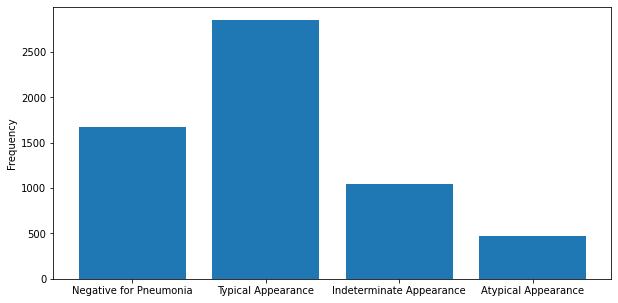

In [17]:
plt.figure(figsize=(10,5))
plt.bar(study_classes, train_study[study_classes].sum())
plt.ylabel('Frequency')
plt.show();

Let's now look at `train_image_level.csv`:

In [18]:
display(train_image.head(), train_image.shape)

,id,boxes,label,StudyInstanceUID
0,000a312787f2_image,"[{'x': 789.28836, 'y': 582.43035, 'width': 1026.65662, 'height': 1917.30292}, {'x': 2245.91208, 'y': 591.20528, 'width': 1094.66162, 'height': 1761.54944}]",opacity 1 789.28836 582.43035 1815.94498 2499.73327 opacity 1 2245.91208 591.20528 3340.5737 2352.75472,5776db0cec75
1,000c3a3f293f_image,NaN,none 1 0 0 1 1,ff0879eb20ed
2,0012ff7358bc_image,"[{'x': 677.42216, 'y': 197.97662, 'width': 867.79767, 'height': 999.78214}, {'x': 1792.69064, 'y': 402.5525, 'width': 617.02734, 'height': 1204.358}]",opacity 1 677.42216 197.97662 1545.21983 1197.75876 opacity 1 1792.69064 402.5525 2409.71798 1606.9105,9d514ce429a7
3,001398f4ff4f_image,"[{'x': 2729, 'y': 2181.33331, 'width': 948.00012, 'height': 604}]",opacity 1 2729 2181.33331 3677.00012 2785.33331,28dddc8559b2
4,001bd15d1891_image,"[{'x': 623.23328, 'y': 1050, 'width': 714, 'height': 1106}, {'x': 2578.56661, 'y': 998.66667, 'width': 662.66667, 'height': 1120}]",opacity 1 623.23328 1050 1337.23328 2156 opacity 1 2578.56661 998.66667 3241.23328 2118.66667,dfd9fdd85a3e


(6334, 4)

We have our bounding box labels provided in the `label` column. The format is as follows:  
`[class ID] [confidence score] [bounding box]`  
* class ID - either `opacity` or `none`
* confidence score - confidence from your neural network model. if none, the confidence is `1`.
* bounding box - typical `xmin ymin xmax ymax` format. If class ID is none, the bounding box is `1 0 0 1 1`.  

The bounding boxes are also provided in easily readable dictionary format in column `boxes`, and the study that each image is a part of is provided in `StudyInstanceUID`.

Let's quick look at the distribution of opacity vs none:

In [19]:
print(train_image.loc[0,'boxes'])
print(train_image.loc[0,'label'])

[{'x': 789.28836, 'y': 582.43035, 'width': 1026.65662, 'height': 1917.30292}, {'x': 2245.91208, 'y': 591.20528, 'width': 1094.66162, 'height': 1761.54944}]
opacity 1 789.28836 582.43035 1815.94498 2499.73327 opacity 1 2245.91208 591.20528 3340.5737 2352.75472


In [20]:
train_image['id'].nunique(), train_image['StudyInstanceUID'].nunique()

(6334, 6054)

In [21]:
duplicate = train_image[train_image['StudyInstanceUID'].duplicated() == True].head()
display(duplicate.head(), duplicate.shape)
# 이 중복된 데이터는 무엇을 의미하는 걸까?
# train_image.csv 이므로, study 단에서 당연히 겹치는게 나온다.

,id,boxes,label,StudyInstanceUID
156,05c063f5cef5_image,NaN,none 1 0 0 1 1,0fd2db233deb
289,0b020a7aff0a_image,NaN,none 1 0 0 1 1,a0254bf8a96e
346,0d4d6acc9ed3_image,NaN,none 1 0 0 1 1,74ba8f2badcb
459,11f46d9df786_image,NaN,none 1 0 0 1 1,bc3e2b05a7f1
551,156cb1f5c689_image,NaN,none 1 0 0 1 1,0fd2db233deb


(5, 4)

In [35]:
double = train_image[train_image['StudyInstanceUID'].duplicated() == True]
double.sort_values(by='StudyInstanceUID', inplace=True)
double.head(20)

,id,boxes,label,StudyInstanceUID,split_label
2862,74077a8e3b7c_image,"[{'x': 2175.24285, 'y': 1123.72368, 'width': 432.26318, 'height': 500.11853}, {'x': 823.1639, 'y': 1324.77631, 'width': 306.60522, 'height': 394.5658}, {'x': 845.78232, 'y': 291.86842, 'width': 201.05261, 'height': 437.28949}]",opacity 1 2175.24285 1123.72368 2607.50603 1623.84221 opacity 1 823.1639 1324.77631 1129.76912 1719.34211 opacity 1 845.78232 291.86842 1046.83493 729.15791,00f9e183938e,"[[opacity, 1, 2175.24285, 1123.72368, 2607.50603, 1623.84221], [opacity, 1, 823.1639, 1324.77631, 1129.76912, 1719.34211], [opacity, 1, 845.78232, 291.86842, 1046.83493, 729.15791]]"
6061,f5451a98d684_image,NaN,none 1 0 0 1 1,0142feaef82f,"[[none, 1, 0, 0, 1, 1]]"
5807,ea2117b53323_image,NaN,none 1 0 0 1 1,0369e0385796,"[[none, 1, 0, 0, 1, 1]]"
2566,67ea53f37acf_image,"[{'x': 1996.08742, 'y': 981.46708, 'width': 618.36841, 'height': 745.5329}, {'x': 539.9295, 'y': 831.86182, 'width': 907.60529, 'height': 790.41455}]",opacity 1 1996.08742 981.46708 2614.45583 1726.99998 opacity 1 539.9295 831.86182 1447.53479 1622.27637,061d2ddaddd1,"[[opacity, 1, 1996.08742, 981.46708, 2614.45583, 1726.99998], [opacity, 1, 539.9295, 831.86182, 1447.53479, 1622.27637]]"
5909,eea3a910fa9e_image,NaN,none 1 0 0 1 1,066b12d875eb,"[[none, 1, 0, 0, 1, 1]]"
3861,9d45a7e2deda_image,"[{'x': 459.58234, 'y': 1203.17191, 'width': 791.96124, 'height': 953.39966}, {'x': 1754.13425, 'y': 965.58343, 'width': 843.74341, 'height': 1166.62}]",opacity 1 459.58234 1203.17191 1251.54358 2156.57157 opacity 1 1754.13425 965.58343 2597.87766 2132.20343,075544a7881c,"[[opacity, 1, 459.58234, 1203.17191, 1251.54358, 2156.57157], [opacity, 1, 1754.13425, 965.58343, 2597.87766, 2132.20343]]"
5721,e60a47d36e62_image,NaN,none 1 0 0 1 1,0949b847bda6,"[[none, 1, 0, 0, 1, 1]]"
3268,84a8af741443_image,"[{'x': 483.54445, 'y': 980, 'width': 942.66667, 'height': 770}, {'x': 1724.87779, 'y': 830.66667, 'width': 868, 'height': 1325.33333}]",opacity 1 483.54445 980 1426.21112 1750 opacity 1 1724.87779 830.66667 2592.87779 2156.0,0a256a4617e8,"[[opacity, 1, 483.54445, 980, 1426.21112, 1750], [opacity, 1, 1724.87779, 830.66667, 2592.87779, 2156.0]]"
3707,961e67cadcdc_image,"[{'x': 63.92032, 'y': 655.62553, 'width': 642.91285, 'height': 687.90442}]",opacity 1 63.92032 655.62553 706.83317 1343.52995,0b1671929731,"[[opacity, 1, 63.92032, 655.62553, 706.83317, 1343.52995]]"
3821,9b1de1c45491_image,NaN,none 1 0 0 1 1,0d33fb757a01,"[[none, 1, 0, 0, 1, 1]]"


In [22]:
train_image['split_label'] = train_image['label'].map(lambda x: [x.split()[i:i+6] for i in range(0, len(x.split()), 6) ] )

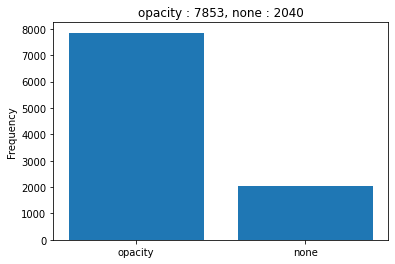

In [23]:
classes_freq = {'opacity':0, 'none':0}
for i in range(len(train_image)):
    for j in train_image.iloc[i, 4]:
        classes_freq[j[0]] += 1
plt.bar(classes_freq.keys(), classes_freq.values())
plt.ylabel('Frequency')
plt.title(f"opacity : {classes_freq['opacity']}, none : {classes_freq['none']}")
plt.show();

Let's look at the distribution of the bounding box areas:

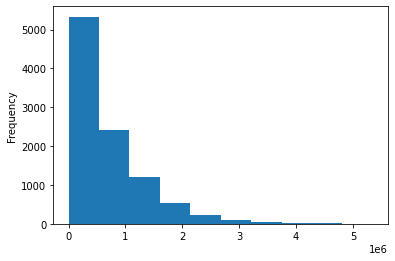

In [24]:
bbox_areas = []
for i in range(len(train_image)):
    for j in train_image.iloc[i, 4]:
        bbox_areas.append((float(j[5]) - float(j[3])) * (float(j[4]) - float(j[2])))
plt.hist(bbox_areas)
plt.ylabel('Frequency')
plt.show();

## A look at the images

[dicom file 처리 관련 한국 블로그](https://ballentain.tistory.com/53)

In [25]:
def dicom2array(path, voi_lut=True, fix_monochrome=True):
    dicom = pydicom.read_file(path) # 메타데이터를 읽어들임
    # VOI_LUT (if available by DICOM device) is used to
    # transform raw DICOM data to "human-friendly" view
    if voi_lut:
        data = apply_voi_lut(dicom.pixel_array, dicom)
    else:
        data = dicom.pixel_array # numpy array 로 변경
    # depending on this value, X-ray may look inverted -fix that:
    if fix_monochrome and dicom.PhotometricInterpretation == 'MONOCHROME1':
        data = np.amax(data) - data # np.amax = np.max
    data = data - np.min(data)
    data = data / np.max(data)
    data = (data * 255).astype(np.uint8)
    return data

# MONOCHROME1 : 0 밝음 255 어두움 (그레이스케일)
# MONOCHROME2 : 0 어두움 255 밝음 (그레이스케일)

# TODO : voi_lut
# fix_monochrome

# 이렇게 하면 엄밀히 말해서, 밝기가 다른 것들이 뭉개지지 않는가?

def plot_img(img, size=(7,7), is_rgb=True, title="", cmap='gray'):
    plt.figure(figsize=size)
    plt.imshow(img, cmap=cmap)
    plt.suptitle(title)
    plt.show();
    
def plot_imgs(imgs, cols=4, size=7, is_rgb=True, title="", cmap='gray', img_size=(500,500)):
    rows = len(imgs)//cols + 1
    fig = plt.figure(figsize=(cols*size, rows*size))
    for i, img in enumerate(imgs):
        if img_size is not None:
            img = cv2.resize(img, img_size)
        fig.add_subplot(rows, cols, i+1)
        plt.imshow(img, cmap=cmap)
    plt.suptitle(title)
    plt.show()

In [26]:
def get_dicom_files(path):
    file_list = []
    for dirname, _, filenames in os.walk(path): # 폴더 하나하나 다 순회
        for filename in filenames: # = 폴더 내에 file 이 있을 경우
            file_list.append(os.path.join(dirname, filename))
    return file_list

dicom_path = get_dicom_files(TRAIN_PATH)

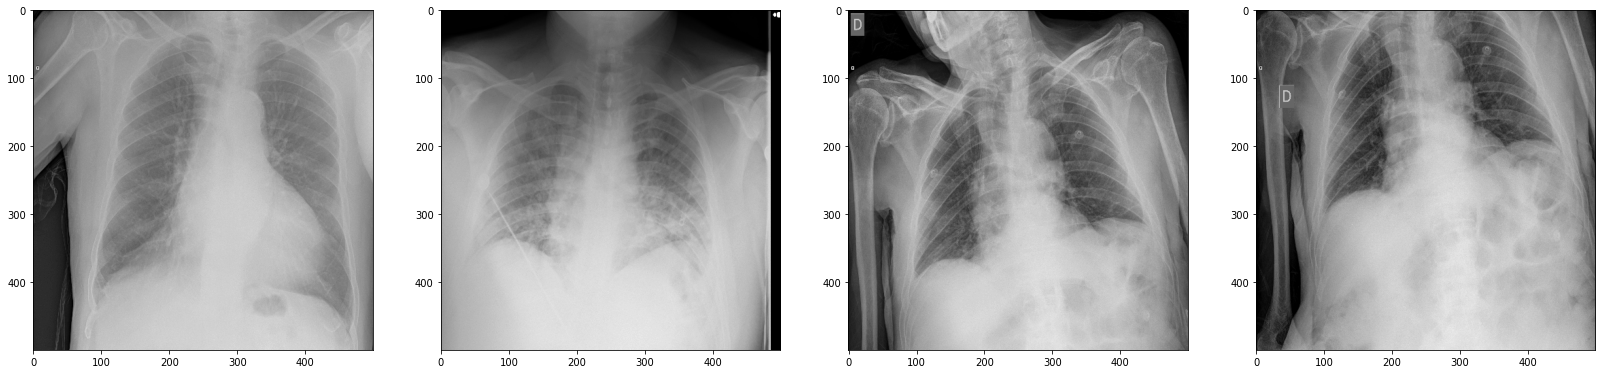

In [27]:
imgs = [dicom2array(path) for path in dicom_path[:4]]
plot_imgs(imgs)

Let's actually look at how many images are available per study:

In [28]:
dataset_path = Path('../input/siim-covid19-detection')
dataset_path.ls()

(#5) [Path('../input/siim-covid19-detection/sample_submission.csv'),Path('../input/siim-covid19-detection/train_image_level.csv'),Path('../input/siim-covid19-detection/test'),Path('../input/siim-covid19-detection/train'),Path('../input/siim-covid19-detection/train_study_level.csv')]

In [29]:
num_images_per_study = []
for i in (dataset_path/'train').ls():
    num_images_per_study.append(len(get_dicom_files(i)))
    if len(get_dicom_files(i)) > 5:
        print(f"Study {i} had {len(get_dicom_files(i))} images")

Study ../input/siim-covid19-detection/train/8943d1d85097 had 6 images
Study ../input/siim-covid19-detection/train/0fd2db233deb had 9 images
Study ../input/siim-covid19-detection/train/a7335b2f9815 had 7 images


In [40]:
num_images_per_study = []
count = 0
for i in (dataset_path/'train').ls():
    num_images_per_study.append(len(get_dicom_files(i)))
    if len(get_dicom_files(i)) > 1:
        count += 1
        print(f"Study {i} had {len(get_dicom_files(i))} images")
print(count)

Study ../input/siim-covid19-detection/train/e4b50e7402c3 had 2 images
Study ../input/siim-covid19-detection/train/ba27bcbd6881 had 2 images
Study ../input/siim-covid19-detection/train/79c3bf957d49 had 4 images
Study ../input/siim-covid19-detection/train/81f6b4b343f7 had 3 images
Study ../input/siim-covid19-detection/train/1b5ca94ac38b had 2 images
Study ../input/siim-covid19-detection/train/95796dc2eced had 2 images
Study ../input/siim-covid19-detection/train/214a48cfa07d had 2 images
Study ../input/siim-covid19-detection/train/68a7d37d581f had 2 images
Study ../input/siim-covid19-detection/train/fae06a05819a had 2 images
Study ../input/siim-covid19-detection/train/f689f3fba17a had 2 images
Study ../input/siim-covid19-detection/train/c804cb63b917 had 2 images
Study ../input/siim-covid19-detection/train/11a47a5bfa3e had 2 images
Study ../input/siim-covid19-detection/train/bb8d7ff318fd had 2 images
Study ../input/siim-covid19-detection/train/2c62594e961b had 2 images
Study ../input/siim-

In [37]:
#연구 하나에도 폴더가 여러개 -> 한 연구에서 각 폴더에 들어있는 것들이 어떻게 구성되어있는지 확인해보자.
glob('../input/siim-covid19-detection/train/79c3bf957d49/*')

['../input/siim-covid19-detection/train/79c3bf957d49/aa1b93580de6',
 '../input/siim-covid19-detection/train/79c3bf957d49/fb07235d8e4f',
 '../input/siim-covid19-detection/train/79c3bf957d49/02687bf3a14f',
 '../input/siim-covid19-detection/train/79c3bf957d49/3c6987e96032']

In [41]:
sample = glob('../input/siim-covid19-detection/train/79c3bf957d49/*')
for i in range(len(sample)):
    print(glob(sample[i] + '/*'))

['../input/siim-covid19-detection/train/79c3bf957d49/aa1b93580de6/f7edf5c476c4.dcm']
['../input/siim-covid19-detection/train/79c3bf957d49/fb07235d8e4f/4cbc17936e7d.dcm']
['../input/siim-covid19-detection/train/79c3bf957d49/02687bf3a14f/d4131bd4e64a.dcm']
['../input/siim-covid19-detection/train/79c3bf957d49/3c6987e96032/582c442e440b.dcm']


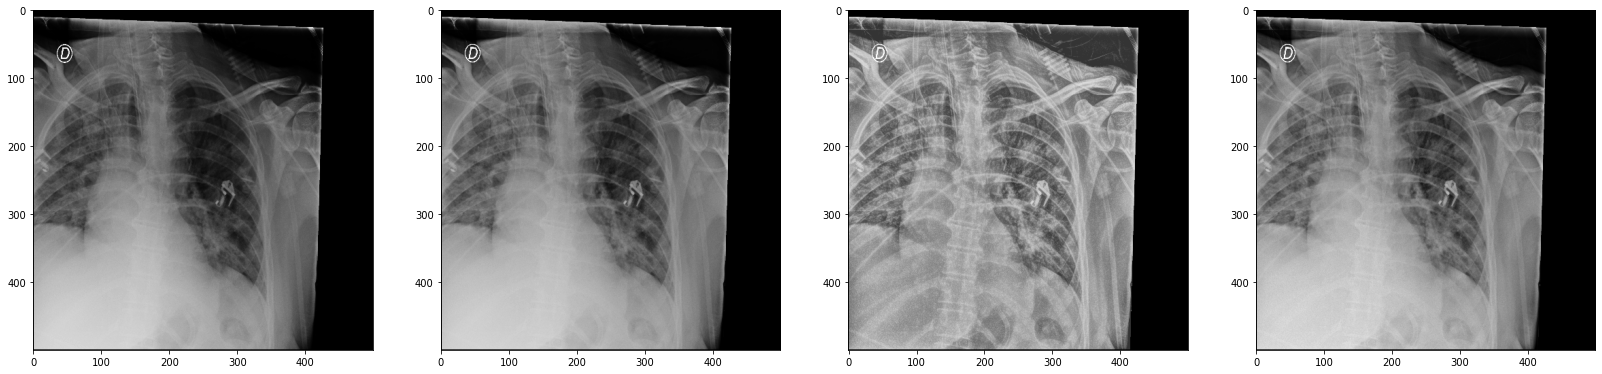

In [42]:
temp_list = []
for i in range(len(sample)):
    temp_list.append(glob(sample[i] + '/*')[0])
imgs = [dicom2array(path) for path in temp_list[:4]]
plot_imgs(imgs)

### image 변환하여 저장하는 Notebook   
[[Notebook] 이미지 변환 저장 참고 노트북](https://www.kaggle.com/madquer/convert-512-img-600-study-png/edit)  
이 노트북의 변환과정에 따르면,  
image_level 에서는 위의 4개 모두가 저장될 것이고,    
study_level 에서는 위 사진 중 마지막 사진이 study_level 용 데이터로 저장될 것이다.   
정말 엄밀히 하자면, image_level 은 어차피 모든 boxes 를 다 예측하는데, study_level 은 이 중 하나만 선택된다.   
**image_level 에 따라 맞춰가면서 학습에 이용할 study_level 을 선정하는 것도 중요하겠다.**  
**또한, 코드를 수정하여 4가지 사진 모두에 대해 학습시켜 볼 수 도 있겠다.**

(array([5.822e+03, 2.070e+02, 1.500e+01, 4.000e+00, 0.000e+00, 3.000e+00,
        1.000e+00, 1.000e+00, 0.000e+00, 1.000e+00]),
 array([1. , 1.8, 2.6, 3.4, 4.2, 5. , 5.8, 6.6, 7.4, 8.2, 9. ]),
 <BarContainer object of 10 artists>)

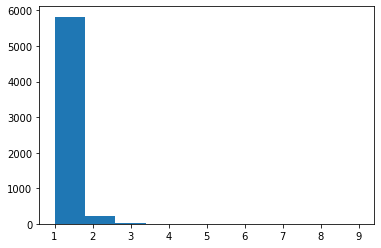

In [30]:
plt.hist(num_images_per_study)

In [47]:
display(train_image.head(), train_image.shape)

,id,boxes,label,StudyInstanceUID,split_label
0,000a312787f2_image,"[{'x': 789.28836, 'y': 582.43035, 'width': 1026.65662, 'height': 1917.30292}, {'x': 2245.91208, 'y': 591.20528, 'width': 1094.66162, 'height': 1761.54944}]",opacity 1 789.28836 582.43035 1815.94498 2499.73327 opacity 1 2245.91208 591.20528 3340.5737 2352.75472,5776db0cec75,"[[opacity, 1, 789.28836, 582.43035, 1815.94498, 2499.73327], [opacity, 1, 2245.91208, 591.20528, 3340.5737, 2352.75472]]"
1,000c3a3f293f_image,NaN,none 1 0 0 1 1,ff0879eb20ed,"[[none, 1, 0, 0, 1, 1]]"
2,0012ff7358bc_image,"[{'x': 677.42216, 'y': 197.97662, 'width': 867.79767, 'height': 999.78214}, {'x': 1792.69064, 'y': 402.5525, 'width': 617.02734, 'height': 1204.358}]",opacity 1 677.42216 197.97662 1545.21983 1197.75876 opacity 1 1792.69064 402.5525 2409.71798 1606.9105,9d514ce429a7,"[[opacity, 1, 677.42216, 197.97662, 1545.21983, 1197.75876], [opacity, 1, 1792.69064, 402.5525, 2409.71798, 1606.9105]]"
3,001398f4ff4f_image,"[{'x': 2729, 'y': 2181.33331, 'width': 948.00012, 'height': 604}]",opacity 1 2729 2181.33331 3677.00012 2785.33331,28dddc8559b2,"[[opacity, 1, 2729, 2181.33331, 3677.00012, 2785.33331]]"
4,001bd15d1891_image,"[{'x': 623.23328, 'y': 1050, 'width': 714, 'height': 1106}, {'x': 2578.56661, 'y': 998.66667, 'width': 662.66667, 'height': 1120}]",opacity 1 623.23328 1050 1337.23328 2156 opacity 1 2578.56661 998.66667 3241.23328 2118.66667,dfd9fdd85a3e,"[[opacity, 1, 623.23328, 1050, 1337.23328, 2156], [opacity, 1, 2578.56661, 998.66667, 3241.23328, 2118.66667]]"


(6334, 5)

In [64]:
dataset_path

Path('../input/siim-covid19-detection')

In [68]:
Path('../input/siim-covid19-detection/train/5776db0cec75/81456c9c5423/000a312787f2.dcm').stem

'000a312787f2'

In [70]:
def image_path(row):
    study_path = dataset_path/'train'/row.StudyInstanceUID
    for i in get_dicom_files(study_path):
        i = Path(i) # change to Path data type (only in this notebook)
        if row.id.split('_')[0] == i.stem: 
            return i
        
train_image['image_path'] = train_image.apply(image_path, axis=1)

In [71]:
train_image.loc[0,['id','StudyInstanceUID','image_path']]

id                                                                                000a312787f2_image
StudyInstanceUID                                                                        5776db0cec75
image_path          ../input/siim-covid19-detection/train/5776db0cec75/81456c9c5423/000a312787f2.dcm
Name: 0, dtype: object

../input/siim-covid19-detection/train/a0fa7251455a/cd8736126235/ea743e2eccf9.dcm
../input/siim-covid19-detection/train/c4ded198c3f1/b34a80f81d92/eef9600e5493.dcm
../input/siim-covid19-detection/train/425baa3b6167/405fe962c487/4fc2c59d28a1.dcm
../input/siim-covid19-detection/train/7359a4fd6f06/1d8d21a090fb/fde8fb309565.dcm
../input/siim-covid19-detection/train/3823cf1c6958/712bf2fb4521/2e10eba82c2b.dcm
../input/siim-covid19-detection/train/af4e1dfa2f63/a08655135000/f258c4e97218.dcm
../input/siim-covid19-detection/train/c1ecb74c1260/81c1a3572038/12384ae3a66c.dcm
../input/siim-covid19-detection/train/691a323878a5/9246ab796337/0846e5c4dfd2.dcm


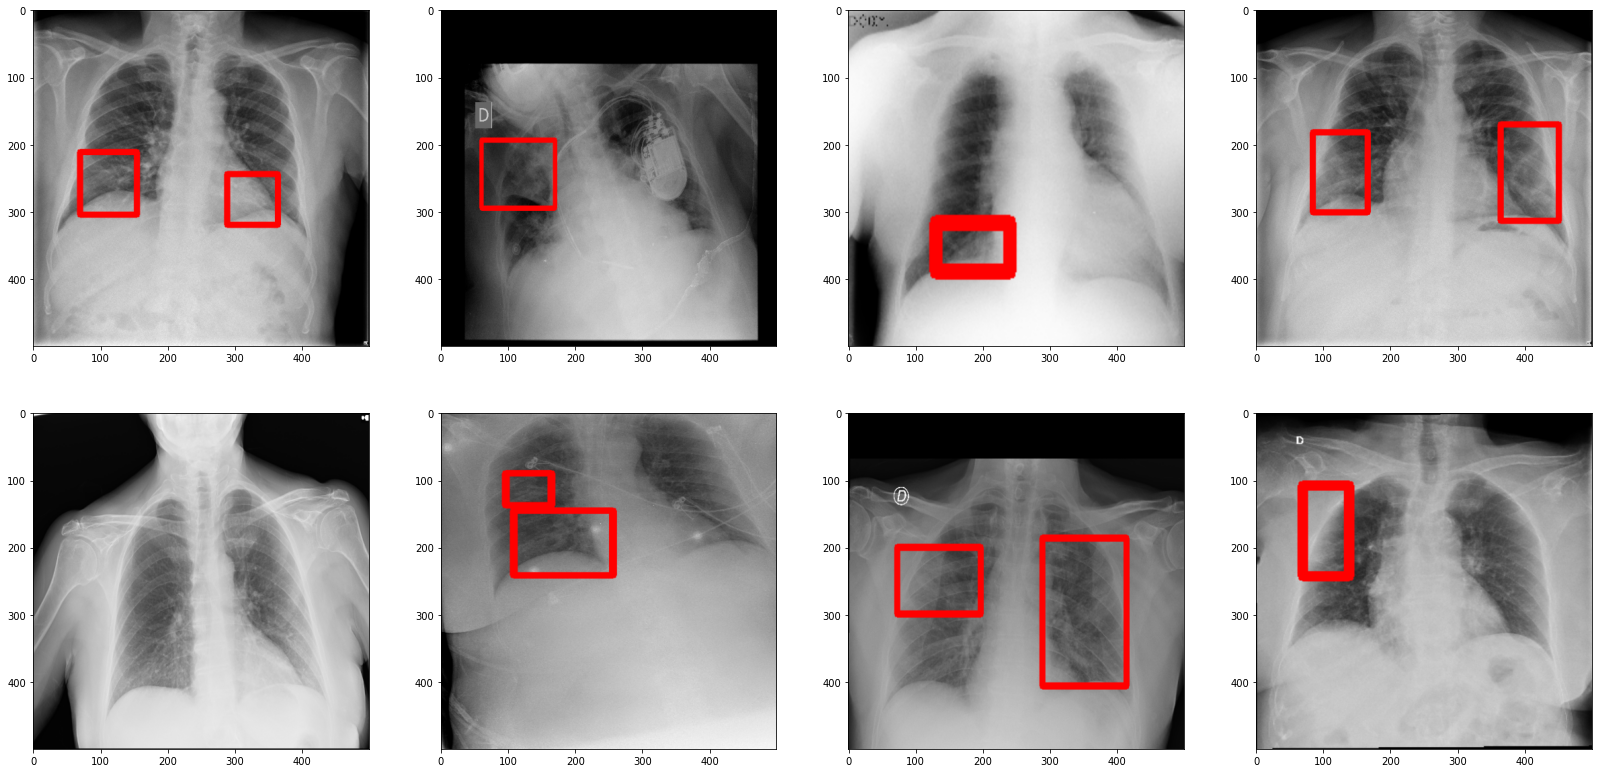

In [72]:
imgs = []
image_paths = train_image['image_path'].values

# map label_id to specify color
thickness = 10
scale = 5

for i in range(8):
    image_path = random.choice(image_paths)
    print(image_path)
    img = dicom2array(path=image_path)
    img = cv2.resize(img, None, fx=1/scale, fy=1/scale)
    img = np.stack([img, img, img], axis=-1)
    for i in train_image.loc[train_image['image_path']==image_path].split_label.values[0]:
        if i[0] == 'opacity':
            img = cv2.rectangle(img,
                                (int(float(i[2])/scale), int(float(i[3])/scale)),
                                (int(float(i[4])/scale), int(float(i[5])/scale)),
                                [255,0,0], thickness)
    img = cv2.resize(img, (500,500))
    imgs.append(img)
    
plot_imgs(imgs, cmap=None)

## How to submit
Let's now go over the `sample_submission.csv` file so we know how to submit our predictions.  

Before we do so, it's worth reminding ourselves that this is a code-only competition, meaning that your submission file has to be generated in a script/notebook. The `sample_submission.csv` file demonstrated what kind of file needs to be produced:

In [73]:
submission.head()

,id,PredictionString
0,00188a671292_study,negative 1 0 0 1 1
1,004bd59708be_study,negative 1 0 0 1 1
2,00508faccd39_study,negative 1 0 0 1 1
3,006486aa80b2_study,negative 1 0 0 1 1
4,00655178fdfc_study,negative 1 0 0 1 1


We can see we have to provide the study-level class label. These will be of the format `[class]` `1 0 0 1 1`

In [74]:
submission.iloc[1990:2000]

,id,PredictionString
1990,2a1dae5f6b5f_image,none 1 0 0 1 1
1991,b576b0f1eeac_image,none 1 0 0 1 1
1992,eb4d5d8af5a5_image,none 1 0 0 1 1
1993,ce34bdbe98b5_image,none 1 0 0 1 1
1994,7c77f9aa3a25_image,none 1 0 0 1 1
1995,cb75251076c7_image,none 1 0 0 1 1
1996,fd65cc14da23_image,none 1 0 0 1 1
1997,c6fa6b9b8093_image,none 1 0 0 1 1
1998,e5e44940be7a_image,none 1 0 0 1 1
1999,3a2aa71a792e_image,none 1 0 0 1 1


We also have to provide the image-level bounding box. These will be of the format `[class ID]` `[confidence score]` `[bounding box]` as described earlier.  

Of course, in both cases, you can have multi-label scenarios.

## TO KNOW MORE
1. what is exactly that image_level, study_level?
2. what is confidence score?